# Análisis de incidencia de violencia

In [1]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols

file="Cuestionario receptoras y receptoras potenciales de programas de transferencias condicionadas.xlsx"
df=pd.read_excel(file,sheet_name="Resultado")

clas=pd.read_excel("Clasificacion.xlsx")


## El siguiente código agrupa a la muestra en función del tipo de programa al que se le asocia, y genera ANOVAs para cada una de las preguntas del violentómetro para identificar si existe diferencias entre los grupos

In [2]:
#prepare to map ordinal values to responses that require it
frequency_mapping = {'Nunca': 1, 'Una vez': 2, 'Varias veces': 3, 'Muchas veces': 4}
cols_to_map=['Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [La ha menospreciado a solas o frente a otras personas]',
       'Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [La ha insultado]',
       'Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [Se ha puesto celoso o ha sospechado de sus amistades]',
       'Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [Le ha dicho cosas como que sea poco atractiva]',
       'Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [La ha amenazado con golpearla]',
       'Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [Ha destruido alguna de sus cosas]',
       'Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [La ha golpeado]',
       'Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [Le ha hecho sentir miedo de él]',
       'Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [La ha amenazado con lastimar a sus hijos/as]',
       'Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [Le ha controlado su dinero o quitándoselo]',
       'Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [La ha amenazado con irse con otras mujeres]',
       'Participación en la toma de decisiones al interior del hogar ¿Cuántas veces su esposo o compañero decide...? [Si usted debe o puede trabajar]',
       'Participación en la toma de decisiones al interior del hogar ¿Cuántas veces su esposo o compañero decide...? [Cómo se gasta el dinero en casa]',
       'Participación en la toma de decisiones al interior del hogar ¿Cuántas veces su esposo o compañero decide...? [La compra de los bienes]',
       'Participación en la toma de decisiones al interior del hogar ¿Cuántas veces su esposo o compañero decide...? [Si puede o no usar anticonceptivos]',
       'Participación en la toma de decisiones al interior del hogar ¿Cuántas veces su esposo o compañero decide...? [La disciplina y cómo castigar a los hijos/as]',
       'Participación en la toma de decisiones al interior del hogar ¿Cuántas veces su esposo o compañero decide...? [Cuántos hijos/as tener]',
       'Libertad personal ¿Cuántas veces su esposo o compañero decide...? [Qué tipo de ropa puede usar]',
       'Libertad personal ¿Cuántas veces su esposo o compañero decide...? [Con qué personas puede juntarse]',
       'Libertad personal ¿Cuántas veces su esposo o compañero decide...? [Con qué frecuencia puede ver a su familia y/o amistades]']

psyc_viol=df[['Edad', 'Nivel máximo de escolaridad','Estado civil','Si tiene hijos/as ¿Cuántos?','Ocupación (selecciona todas las que apliquen).1',
              'Ingreso semanal','¿Su ingreso es estable? es decir, ¿cada mes recibe la misma cantidad?',"Monto de la transferencia 1"]]
econ_viol=psyc_viol
phys_viol=psyc_viol
sex_viol=psyc_viol


#Add responses to blank values
df["Programa1.Condicion"].fillna("Sin programa", inplace=True)

#Create df to save ANOVA results
result_df=pd.DataFrame(columns=("Pregunta","F-statistic","p_value","Relevancia"))

#Create list to save Tukey results
tukey_results_list=[]

#Create list to save means
means_list=[]

#Run ANOVAs and Tukeys
for col in cols_to_map:
    
    #map ordinals to categoricals
    df["Encoded_freq"]=df[col].map(frequency_mapping)
    
    #categorize violence
    
    if col in list(clas[clas["Tipo de Violencia"]=="Psicológica"]["Pregunta"]):
        psyc_viol=pd.concat([psyc_viol,df[col]],axis=1)
    elif col in list(clas[clas["Tipo de Violencia"]=="Económica/Patrimonial"]["Pregunta"]):
        econ_viol=pd.concat([econ_viol,df[col]],axis=1)
    elif col in list(clas[clas["Tipo de Violencia"]=="Sexual"]["Pregunta"]):
        sex_viol= pd.concat([sex_viol,df[col]],axis=1)
    else:
        phys_viol=pd.concat([phys_viol,df[col]],axis=1)
    
    #drop nulls
    df_test=df.dropna(subset="Encoded_freq")
    
    #run ANOVAS
    f_statistic, p_value = f_oneway(df_test[df_test["Programa1.Condicion"]=="Condicionado"]["Encoded_freq"],
                                    
                                    df_test[df_test["Programa1.Condicion"] == "Sin condicionantes"]['Encoded_freq'],
                                    df_test[df_test["Programa1.Condicion"] == "Sin programa"]['Encoded_freq'])
    
    if p_value <0.05:
        significance="Reject H0"
    else:
        significance="Fail to reject H0"
    run_df=pd.DataFrame([[col,f_statistic,p_value,significance]],columns=["Pregunta","F-statistic","p_value","Relevancia"])
    
    # Save results
    result_df=pd.concat([result_df,run_df])
    
    #Run Tukey
    tukey_results = pairwise_tukeyhsd(df_test['Encoded_freq'], df_test["Programa1.Condicion"])
    
    #Save Tukey results
    p_adj_values = tukey_results.summary()
    tukey_results_list.append(p_adj_values)
    
    #Save means
    means_list.append(df_test[['Programa1.Condicion','Encoded_freq']].groupby('Programa1.Condicion').mean()
                      .rename({'Encoded_freq':col},axis="columns"))
    
    
result_df=result_df.reset_index().drop(columns="index")
result_df

,Pregunta,F-statistic,p_value,Relevancia
0,Violencia en contra de las mujeres receptoras ...,2.066073,0.132056,Fail to reject H0
1,Violencia en contra de las mujeres receptoras ...,4.578931,0.012510,Reject H0
2,Violencia en contra de las mujeres receptoras ...,4.692229,0.011278,Reject H0
3,Violencia en contra de las mujeres receptoras ...,2.870918,0.061328,Fail to reject H0
4,Violencia en contra de las mujeres receptoras ...,1.738467,0.181060,Fail to reject H0
5,Violencia en contra de las mujeres receptoras ...,1.084612,0.341976,Fail to reject H0
6,Violencia en contra de las mujeres receptoras ...,2.299937,0.105546,Fail to reject H0
7,Violencia en contra de las mujeres receptoras ...,2.231864,0.112648,Fail to reject H0
8,Violencia en contra de las mujeres receptoras ...,4.240673,0.017098,Reject H0
9,Violencia en contra de las mujeres receptoras ...,0.812130,0.446817,Fail to reject H0


## El resultado de la celda anterior muestra el F-score, p-value y la interpretación de cada ANOVA
### La hipótesis nula (H<sub>0</sub>) declara que no hay diferencia estadísticamente significativa entre los grupos. Rechazarla implica que sí hay diferencias.

Tres preguntas del violentómetro indican diferencias estadísticas:
- Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? La ha insultado
- Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? Se ha puesto celoso o ha sospechado de sus amistades
- Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? La ha amenazado con lastimar a sus hijos/as

Se utiliza el método de Tukey para indicar diferencias entre parejas

### Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? La ha insultado

In [3]:
means_list[1]

,Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [La ha insultado]
Programa1.Condicion,
Condicionado,2.885714
Sin condicionantes,2.848485
Sin programa,2.085714


In [4]:
tukey_results_list[1]

group1,group2,meandiff,p-adj,lower,upper,reject
Condicionado,Sin condicionantes,-0.0372,0.9916,-0.7548,0.6804,False
Condicionado,Sin programa,-0.8,0.0225,-1.507,-0.093,True
Sin condicionantes,Sin programa,-0.7628,0.0345,-1.4804,-0.0452,True


Interpretación: La diferencia entre los tipos de programas no es significativa, sin embargo, tener cualquier tipo de programa se correlaciona con un aumento en la violencia

### Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? Se ha puesto celoso o ha sospechado de sus amistades

In [5]:
means_list[2]

,Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [Se ha puesto celoso o ha sospechado de sus amistades]
Programa1.Condicion,
Condicionado,2.971429
Sin condicionantes,3.000000
Sin programa,2.228571


In [6]:
tukey_results_list[2]

group1,group2,meandiff,p-adj,lower,upper,reject
Condicionado,Sin condicionantes,0.0286,0.9946,-0.6572,0.7144,False
Condicionado,Sin programa,-0.7429,0.0275,-1.4185,-0.0672,True
Sin condicionantes,Sin programa,-0.7714,0.0235,-1.4572,-0.0856,True


Interpretación: Ser partícipe de un programa incrementa la incidencia de celos

### Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? La ha amenazado con lastimar a sus hijos/as

In [41]:
means_list[8]

,Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [La ha amenazado con lastimar a sus hijos/as]
Programa1.Condicion,
Condicionado,2.371429
Sin condicionantes,2.000000
Sin programa,1.514286


In [42]:
tukey_results_list[8]

group1,group2,meandiff,p-adj,lower,upper,reject
Condicionado,Sin condicionantes,-0.3714,0.4384,-1.09,0.3471,False
Condicionado,Sin programa,-0.8571,0.0125,-1.5594,-0.1549,True
Sin condicionantes,Sin programa,-0.4857,0.2469,-1.2043,0.2328,False


Interpretación: La violencia aumenta para quienes reciben programas condicionados

## A continuación se clasifican las preguntas del violentometro en distintos tipos de violencia, y se establecen relaciones entre las variables demográficas y la incidencia de violencia

In [7]:
#map and add dfs based on classifications
def df_addition(df):
    available_columns=[]
    for column in df.columns:
        
        if column in cols_to_map:
            df[column]=df[column].map(frequency_mapping)
            available_columns.append(column)
    df["Violencia"]=df[available_columns].sum(axis=1)
df_addition(econ_viol)
df_addition(phys_viol)
df_addition(psyc_viol)
df_addition(sex_viol)

econ_viol

,Edad,Nivel máximo de escolaridad,Estado civil,Si tiene hijos/as ¿Cuántos?,Ocupación (selecciona todas las que apliquen).1,Ingreso semanal,"¿Su ingreso es estable? es decir, ¿cada mes recibe la misma cantidad?",Monto de la transferencia 1,Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [Ha destruido alguna de sus cosas],Violencia en contra de las mujeres receptoras en el ámbito familiar: ¿Cuántas veces su esposo o compañero...? [Le ha controlado su dinero o quitándoselo],Participación en la toma de decisiones al interior del hogar ¿Cuántas veces su esposo o compañero decide...? [Si usted debe o puede trabajar],Participación en la toma de decisiones al interior del hogar ¿Cuántas veces su esposo o compañero decide...? [Cómo se gasta el dinero en casa],Participación en la toma de decisiones al interior del hogar ¿Cuántas veces su esposo o compañero decide...? [La compra de los bienes],Violencia
0,49,Secundaria,Casada,4.0,Ama de casa,1200,No estable,1050.0,1.0,1.0,1.0,1.0,1.0,5.0
1,30,Secundaria,Unión libre,2.0,Emprendedora,300,No estable,2000.0,1.0,1.0,1.0,1.0,1.0,5.0
2,56,Primaria,Casada,6.0,Ama de casa,0,No estable,1050.0,1.0,1.0,4.0,1.0,1.0,8.0
3,39,Secundaria,Unión libre,4.0,Ama de casa,0,No estable,NaN,1.0,1.0,1.0,1.0,1.0,5.0
4,23,Secundaria,Unión libre,1.0,Ama de casa,1000,Estable,NaN,1.0,1.0,1.0,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,72,Sin escolaridad,Divorciada,4.0,Ama de casa,0,No estable,1050.0,2.0,3.0,4.0,4.0,3.0,16.0
102,26,Preparatoria,Soltera,1.0,Emprendedora,1500,No estable,500.0,4.0,4.0,4.0,3.0,4.0,19.0
103,35,Preparatoria,Unión libre,4.0,Empleada,3000,Estable,NaN,4.0,4.0,4.0,4.0,4.0,20.0
104,33,Primaria,Unión libre,3.0,Emprendedora,300,No estable,NaN,2.0,3.0,2.0,3.0,3.0,13.0


# Violencia Economica

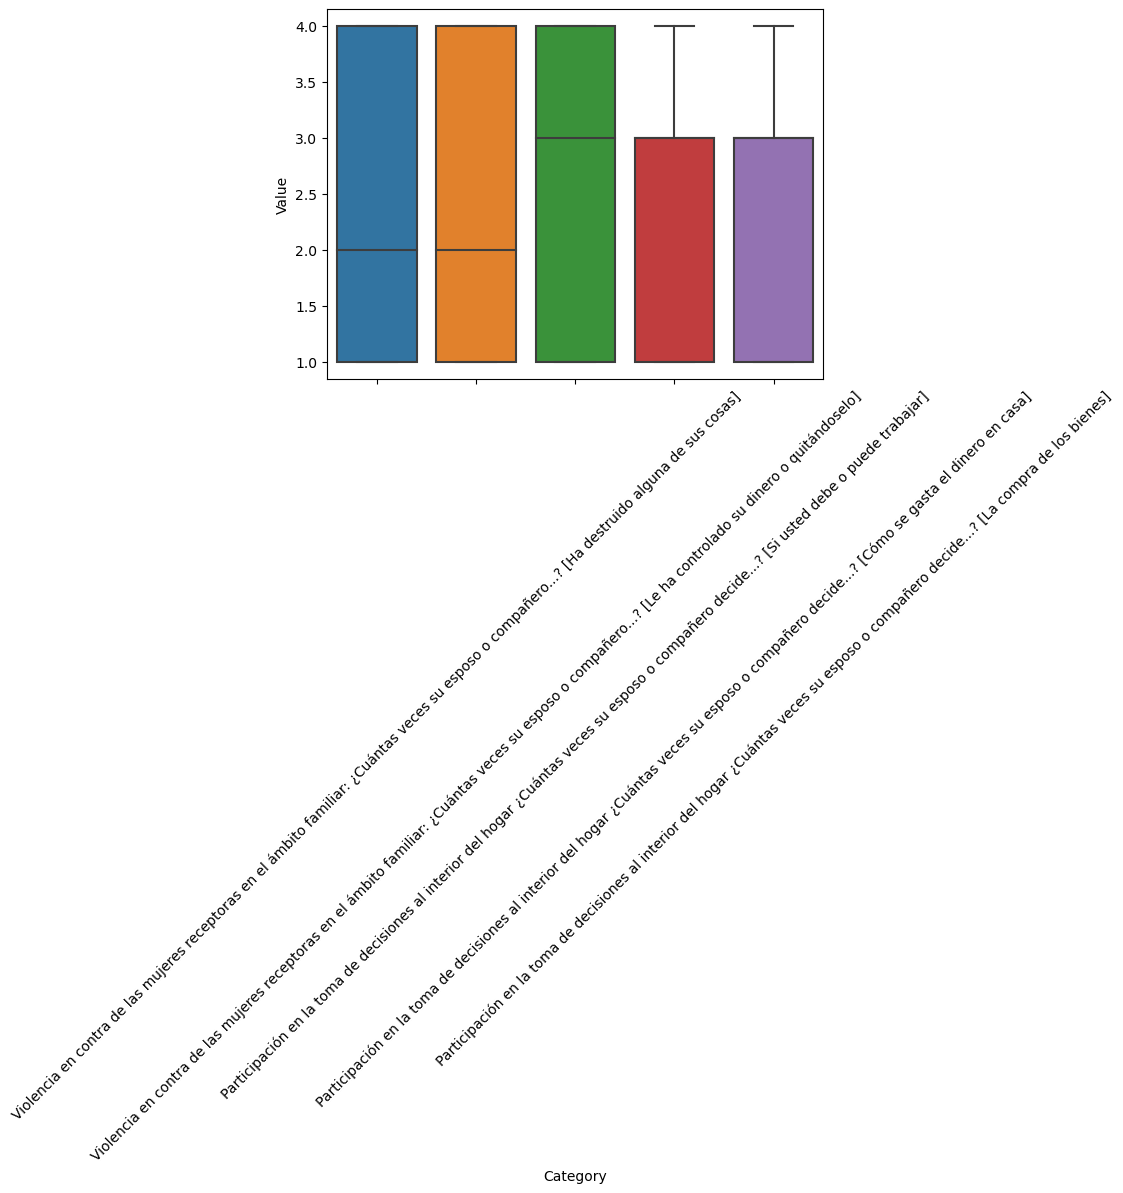

In [59]:

temp_df=econ_viol[["Violencia",'Edad', 'Nivel máximo de escolaridad','Estado civil','Si tiene hijos/as ¿Cuántos?','Ocupación (selecciona todas las que apliquen).1',
              'Ingreso semanal','¿Su ingreso es estable? es decir, ¿cada mes recibe la misma cantidad?',"Monto de la transferencia 1"]]

temp_df.columns=["Violencia","Edad","Escolaridad","Edo_Civil", "Hijos", "Ocupacion", "Ingreso_semanal","Estabilidad","Monto"]

temp_df=temp_df.dropna(subset="Violencia")
mult_reg_y=temp_df["Violencia"]
mult_reg_x=temp_df[[ "Edad","Escolaridad","Edo_Civil", "Hijos", "Ocupacion", "Ingreso_semanal","Estabilidad","Monto"]].fillna(0)

cols_to_exclude=["Violencia",'Edad', 'Nivel máximo de escolaridad','Estado civil','Si tiene hijos/as ¿Cuántos?','Ocupación (selecciona todas las que apliquen).1',
              'Ingreso semanal','¿Su ingreso es estable? es decir, ¿cada mes recibe la misma cantidad?',"Monto de la transferencia 1"]

selected_columns = econ_viol.loc[:, ~econ_viol.columns.isin(cols_to_exclude)]
df_long = pd.melt(selected_columns, var_name='Category', value_name='Value')

# Create a boxplot using Seaborn
sns.boxplot(x='Category', y='Value', data=df_long)
plt.xticks(rotation=45)

# Show the plot
plt.show()


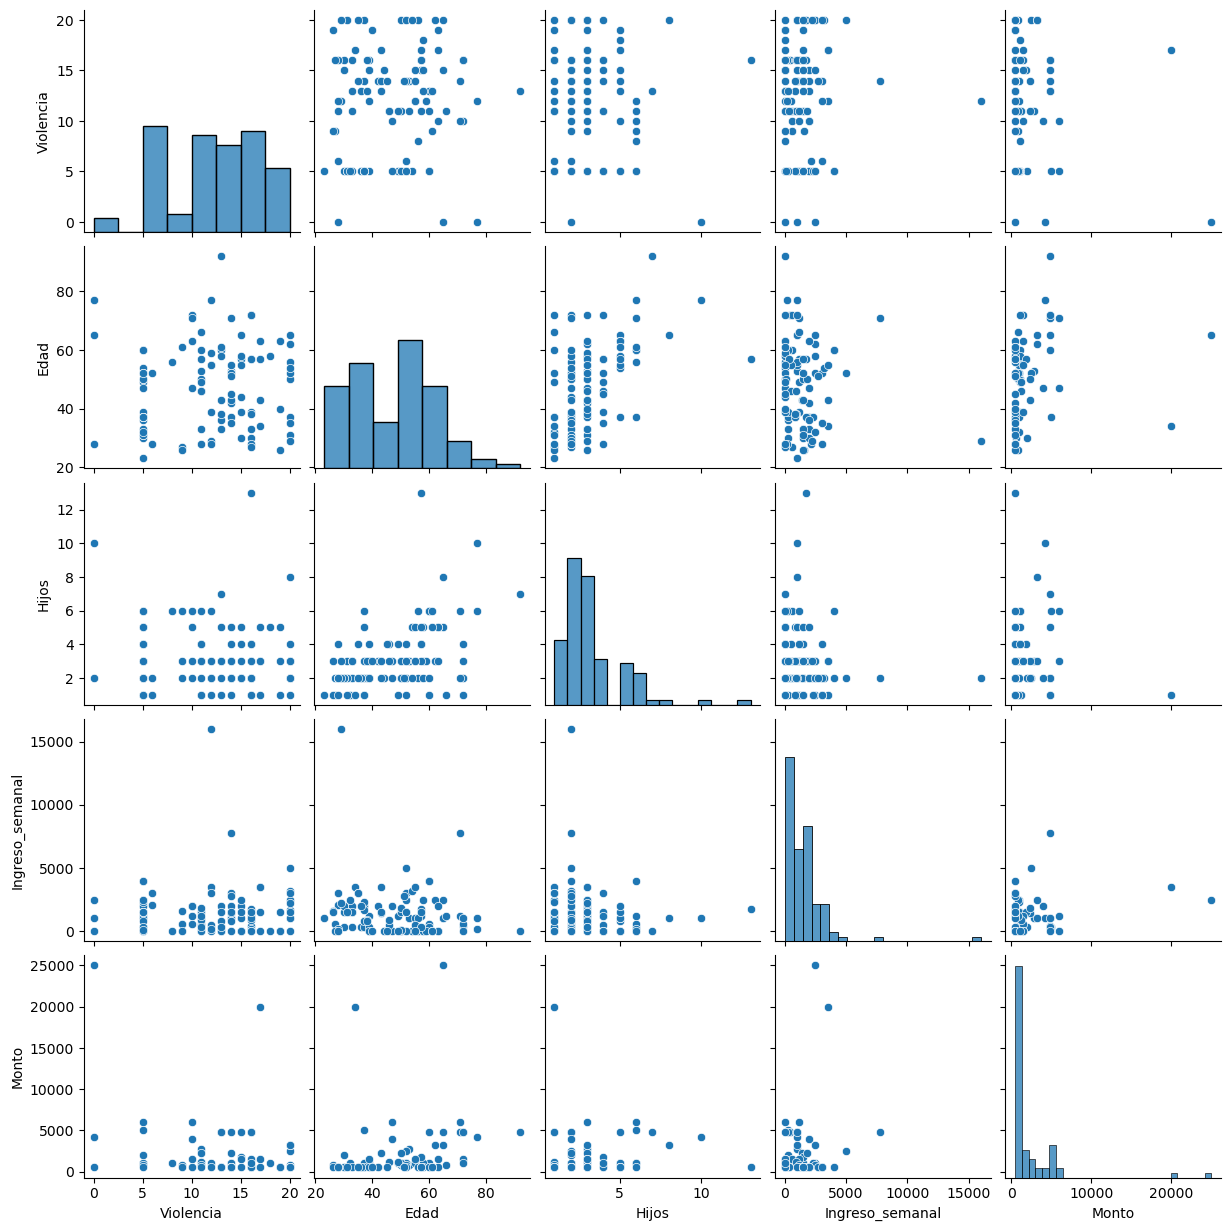

In [9]:
#Visually check for multicolinearity
sns.pairplot(temp_df)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(mult_reg_x, mult_reg_y , test_size=0.3)

In [11]:
ols_formula= "Violencia ~ C(Escolaridad) + C(Edo_Civil) +  Hijos + C(Ocupacion) + C(Estabilidad)"

In [12]:
ols_data = pd.concat([X_train,y_train],axis=1)
OLS =ols(formula=ols_formula, data=ols_data)

In [13]:
model=OLS.fit()

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Violencia   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     1.582
Date:                Sat, 02 Dec 2023   Prob (F-statistic):              0.104
Time:                        20:40:41   Log-Likelihood:                -213.19
No. Observations:                  74   AIC:                             460.4
Df Residuals:                      57   BIC:                             499.5
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             8.0505      2.978      2.704      0.009       2.088      14.013
C(Escolaridad)[T.Primaria]           -1.4094      2.166     -0.651      0.518      -5.747       2.928
C(Escolaridad)[T.Secundaria]         -2.0204      1.922     -1.051      0.298      -5.869       1.828
C(Escolaridad)[T.Sin escolaridad]    -4.1125      2.982     -1.379      0.173     -10.084       1.859
C(Escolaridad)[T.Universidad]         3.7424      3.040      1.231      0.223      -2.344       9.829
C(Edo_Civil)[T.Divorciada]            6.0561      2.997      2.021      0.048       0.055      12.058
C(Edo_Civil)[T.Separada]              2.0632      2.600      0.793      0.431      -3.144       7.270
C(Edo_Civil)[T.Soltera]               2.1215      2.009      1.056      0.295      -1.901       6.144
C(Edo_Civil)[T.Unión libre]           0.4507      1.630      0.277      0.783      -2.813       3.714
C(Edo_Civil)[T.Viuda]                 2.2469      2.358      0.953      0.345      -2.476       6.969
C(Ocupacion)[T.Desempleada]           1.1965      3.465      0.345      0.731      -5.742       8.136
C(Ocupacion)[T.Empleada]              3.3808      1.889      1.790      0.079      -0.402       7.163
C(Ocupacion)[T.Emprendedora]          3.6418      1.729      2.106      0.040       0.180       7.104
C(Ocupacion)[T.Jubilada]              3.0173      5.502      0.548      0.586      -8.000      14.034
C(Ocupacion)[T.Jubilado]             -9.5481      4.603     -2.074      0.043     -18.765      -0.331
C(Estabilidad)[T.No estable]          0.8311      1.850      0.449      0.655      -2.873       4.535
Hijos                                 0.5299      0.382      1.388      0.171      -0.235       1.294
==============================================================================
Omnibus:                        1.483   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.476   Jarque-Bera (JB):                0.861
Skew:                          -0.195   Prob(JB):                        0.650
Kurtosis:                       3.356   Cond. No.                         38.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

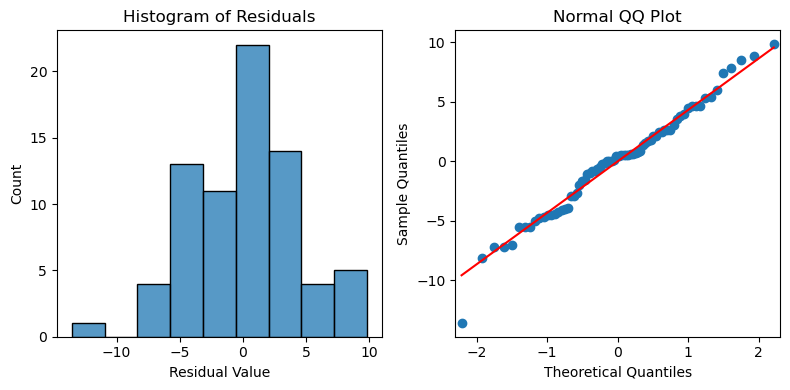

In [15]:
#Check for normality of residuals

residuals=model.resid




# Create a 1x2 plot figure.
fig, axes = plt.subplots(1, 2, figsize = (8,4))


sns.histplot(residuals, ax=axes[0])

# Set the x label of the residual plot.
axes[0].set_xlabel("Residual Value")

# Set the title of the residual plot.
axes[0].set_title("Histogram of Residuals")

# Create a Q-Q plot of the residuals.

sm.qqplot(residuals, line='s',ax = axes[1])

# Set the title of the Q-Q plot.
axes[1].set_title("Normal QQ Plot")

# Use matplotlib's tight_layout() function to add space between plots for a cleaner appearance.
plt.tight_layout()

# Show the plot.
plt.show()

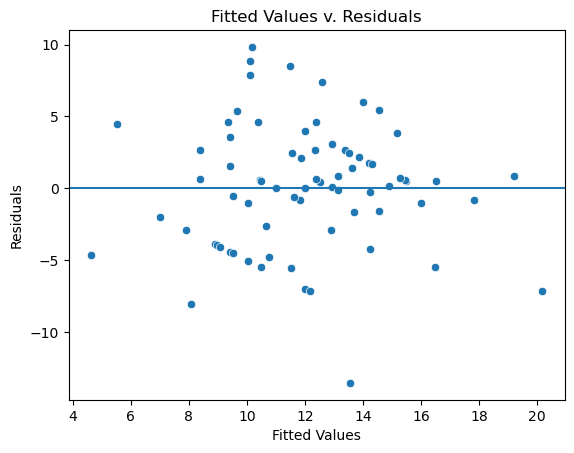

In [16]:
#Check for constant variance
fig = sns.scatterplot(x = model.fittedvalues, y = model.resid)

# Set the x axis label.
fig.set_xlabel("Fitted Values")

# Set the y axis label.
fig.set_ylabel("Residuals")

# Set the title.
fig.set_title("Fitted Values v. Residuals")

# Add a line at y = 0 to visualize the variance of residuals above and below 0.

fig.axhline(0)

# Show the plot.
plt.show()

In [17]:
# Numerically check for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a subset of the data with the continous independent variables. 
X = mult_reg_x[["Hijos", "Monto",]]

# Calculate the variance inflation factor for each variable.
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Create a DataFrame with the VIF results for the column names in X.
df_vif = pd.DataFrame(vif, index=X.columns, columns = ['VIF'])

# Display the VIF results.
df_vif

,VIF
Hijos,1.106083
Monto,1.106083


In [18]:
# Make predictions on the test data
predictions = model.predict(X_test)

# Assuming y_test is a Series, you can compare the predictions with the actual values
results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Display the results
print(results)

# If you want to evaluate the model's performance, you can use metrics such as Mean Squared Error (MSE) or R-squared
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

     Actual  Predicted
27     14.0   9.512689
68     20.0  11.451385
36     14.0  17.887879
13      5.0   8.151620
10      5.0  11.301861
58     11.0  12.673314
35      5.0   7.921065
21      5.0   7.841829
92     19.0   9.061982
65     16.0  12.187694
95     14.0   9.591925
33      5.0   7.391122
30     14.0  11.574120
77     12.0   9.061982
6       5.0  12.941848
32     14.0   9.941472
22      5.0   8.980951
50     20.0  14.113232
44     11.0   9.431658
19      5.0   9.640289
39      5.0   7.619882
29     12.0   8.371772
86     12.0  16.540531
46     20.0  15.443815
85     12.0  13.021084
84     10.0  18.947765
105    12.0  15.174895
34     15.0   9.510894
93     17.0   9.640289
59     13.0  10.725580
97     14.0  18.908818
48     20.0  14.897340
Mean Squared Error: 24.26804426431741
R-squared: 0.06065101770323089


Interpretación: A pesar de que las suposiciones de la regresión multiple se cumplen en este modelo, únicamente se puede explicar al rededor del 30% de la variación de la violencia utilizando las variables propuestas

# Violencia física

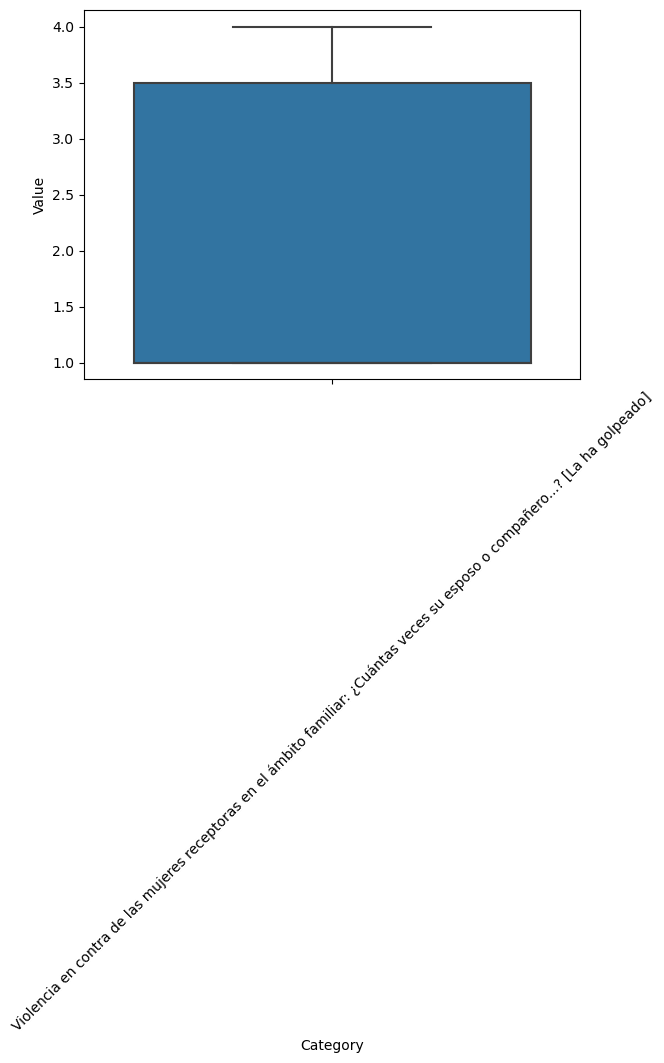

In [60]:
temp_df=phys_viol[["Violencia",'Edad', 'Nivel máximo de escolaridad','Estado civil','Si tiene hijos/as ¿Cuántos?','Ocupación (selecciona todas las que apliquen).1',
              'Ingreso semanal','¿Su ingreso es estable? es decir, ¿cada mes recibe la misma cantidad?',"Monto de la transferencia 1"]]

temp_df.columns=["Violencia","Edad","Escolaridad","Edo_Civil", "Hijos", "Ocupacion", "Ingreso_semanal","Estabilidad","Monto"]

temp_df=temp_df.dropna(subset="Violencia")
mult_reg_y=temp_df["Violencia"]
mult_reg_x=temp_df[[ "Edad","Escolaridad","Edo_Civil", "Hijos", "Ocupacion", "Ingreso_semanal","Estabilidad","Monto"]].fillna(0)

cols_to_exclude=["Violencia",'Edad', 'Nivel máximo de escolaridad','Estado civil','Si tiene hijos/as ¿Cuántos?','Ocupación (selecciona todas las que apliquen).1',
              'Ingreso semanal','¿Su ingreso es estable? es decir, ¿cada mes recibe la misma cantidad?',"Monto de la transferencia 1"]

selected_columns = phys_viol.loc[:, ~phys_viol.columns.isin(cols_to_exclude)]
df_long = pd.melt(selected_columns, var_name='Category', value_name='Value')

# Create a boxplot using Seaborn
sns.boxplot(x='Category', y='Value', data=df_long)
plt.xticks(rotation=45)

# Show the plot
plt.show()


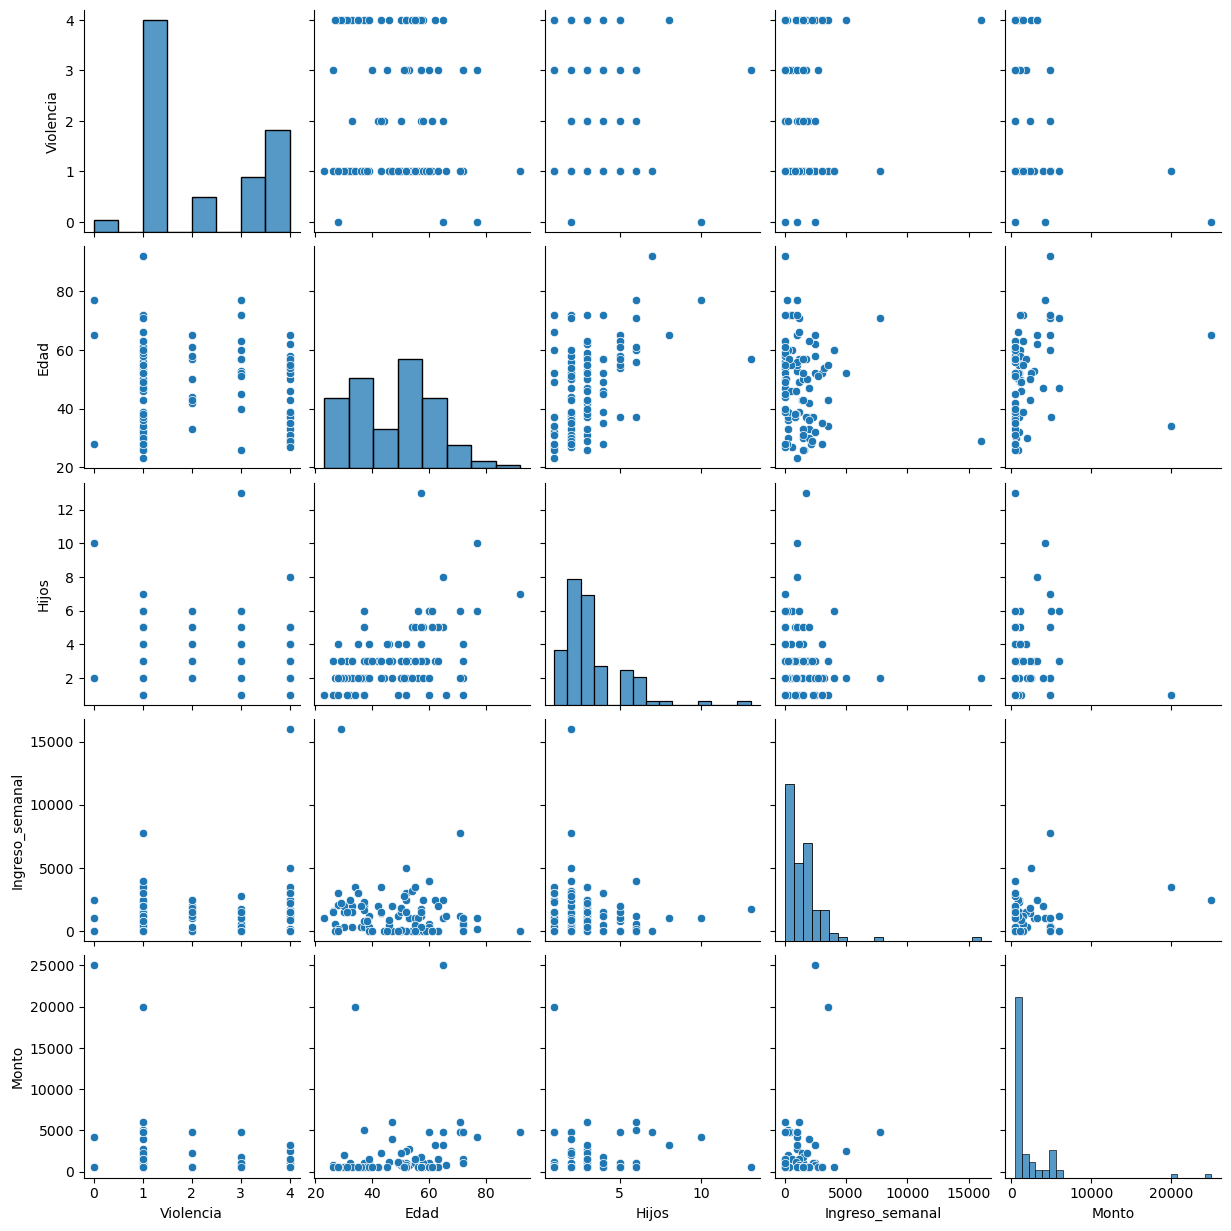

In [20]:
#Visually check for multicolinearity
sns.pairplot(temp_df)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(mult_reg_x, mult_reg_y , test_size=0.1)
ols_formula= "Violencia ~ C(Escolaridad) + C(Edo_Civil) +  Hijos + C(Ocupacion) + C(Estabilidad)"
ols_data = pd.concat([X_train,y_train],axis=1)
OLS =ols(formula=ols_formula, data=ols_data)
model=OLS.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Violencia   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.102
Date:                Sat, 02 Dec 2023   Prob (F-statistic):              0.368
Time:                        20:40:54   Log-Likelihood:                -151.10
No. Observations:                  95   AIC:                             336.2
Df Residuals:                      78   BIC:                             379.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.9030      0.538      1.679      0.097      -0.168       1.974
C(Escolaridad)[T.Primaria]           -0.2894      0.451     -0.642      0.522      -1.186       0.607
C(Escolaridad)[T.Secundaria]          0.0730      0.385      0.190      0.850      -0.693       0.839
C(Escolaridad)[T.Sin escolaridad]    -0.7947      0.764     -1.041      0.301      -2.315       0.726
C(Escolaridad)[T.Universidad]         0.4422      0.731      0.605      0.547      -1.013       1.897
C(Edo_Civil)[T.Divorciada]            0.2326      0.616      0.378      0.707      -0.994       1.459
C(Edo_Civil)[T.Separada]              0.2412      0.606      0.398      0.692      -0.966       1.448
C(Edo_Civil)[T.Soltera]               0.4569      0.487      0.939      0.351      -0.512       1.426
C(Edo_Civil)[T.Unión libre]          -0.3012      0.376     -0.801      0.426      -1.050       0.448
C(Edo_Civil)[T.Viuda]                 0.4399      0.552      0.797      0.428      -0.659       1.539
C(Ocupacion)[T.Desempleada]           0.2683      0.895      0.300      0.765      -1.513       2.049
C(Ocupacion)[T.Empleada]              0.6739      0.393      1.715      0.090      -0.108       1.456
C(Ocupacion)[T.Emprendedora]          0.5968      0.406      1.469      0.146      -0.212       1.405
C(Ocupacion)[T.Jubilada]             -0.6802      1.424     -0.478      0.634      -3.515       2.154
C(Ocupacion)[T.Jubilado]             -1.0211      1.556     -0.656      0.513      -4.118       2.076
C(Estabilidad)[T.No estable]          0.2473      0.382      0.648      0.519      -0.513       1.007
Hijos                                 0.2217      0.086      2.577      0.012       0.050       0.393
==============================================================================
Omnibus:                       32.710   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.087
Skew:                           0.295   Prob(JB):                       0.0289
Kurtosis:                       1.799   Cond. No.                         44.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

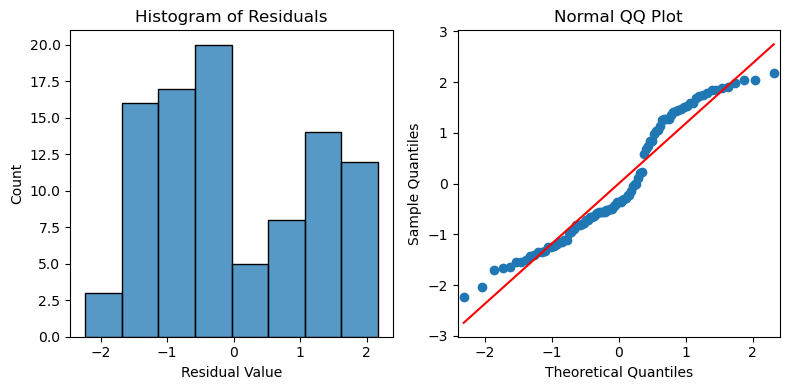

In [22]:
#Check for normality of residuals

residuals=model.resid

# Create a 1x2 plot figure.
fig, axes = plt.subplots(1, 2, figsize = (8,4))


sns.histplot(residuals, ax=axes[0])

# Set the x label of the residual plot.
axes[0].set_xlabel("Residual Value")

# Set the title of the residual plot.
axes[0].set_title("Histogram of Residuals")

# Create a Q-Q plot of the residuals.

sm.qqplot(residuals, line='s',ax = axes[1])

# Set the title of the Q-Q plot.
axes[1].set_title("Normal QQ Plot")

# Use matplotlib's tight_layout() function to add space between plots for a cleaner appearance.
plt.tight_layout()

# Show the plot.
plt.show()

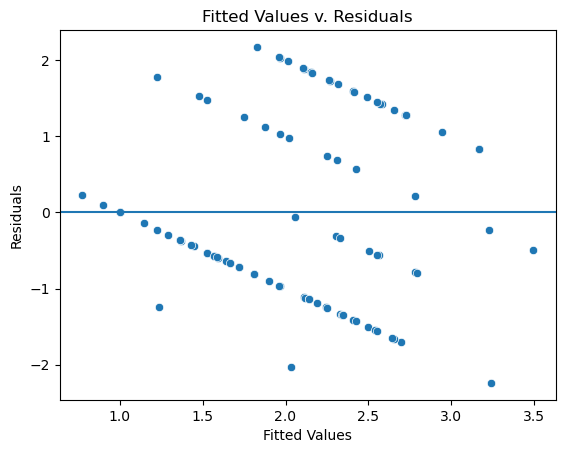

In [23]:
#Check for constant variance

fig = sns.scatterplot(x = model.fittedvalues, y = model.resid)

# Set the x axis label.
fig.set_xlabel("Fitted Values")

# Set the y axis label.
fig.set_ylabel("Residuals")

# Set the title.
fig.set_title("Fitted Values v. Residuals")

# Add a line at y = 0 to visualize the variance of residuals above and below 0.

fig.axhline(0)

# Show the plot.
plt.show()

In [24]:
# Numerically check for multicolinearity
# Create a subset of the data with the continous independent variables. 
X = mult_reg_x[["Hijos", "Monto",]]

# Calculate the variance inflation factor for each variable.
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Create a DataFrame with the VIF results for the column names in X.
df_vif = pd.DataFrame(vif, index=X.columns, columns = ['VIF'])

# Display the VIF results.
df_vif

,VIF
Hijos,1.106083
Monto,1.106083


In [25]:
# Make predictions on the test data
predictions = model.predict(X_test)

# Assuming y_test is a Series, you can compare the predictions with the actual values
results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Display the results
print(results)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

     Actual  Predicted
40      0.0   2.249251
57      1.0   2.630852
13      1.0   0.755739
15      1.0   2.331739
94      4.0   2.047906
90      3.0   1.316199
71      4.0   1.740544
26      1.0   2.357909
29      1.0   1.365458
24      1.0   1.952573
104     2.0   1.821484
Mean Squared Error: 2.2017947747394575
R-squared: -0.33208583871737263


Interpretación: Ya que la varianza no es constante, ni los residuales se distribuyen normalmente, este modelo no representa de forma adecuada la relación entre las variables seleccionadas y la violencia física. Más investigación y otros métodos estadísticos son necesarios

# Violencia psicológica

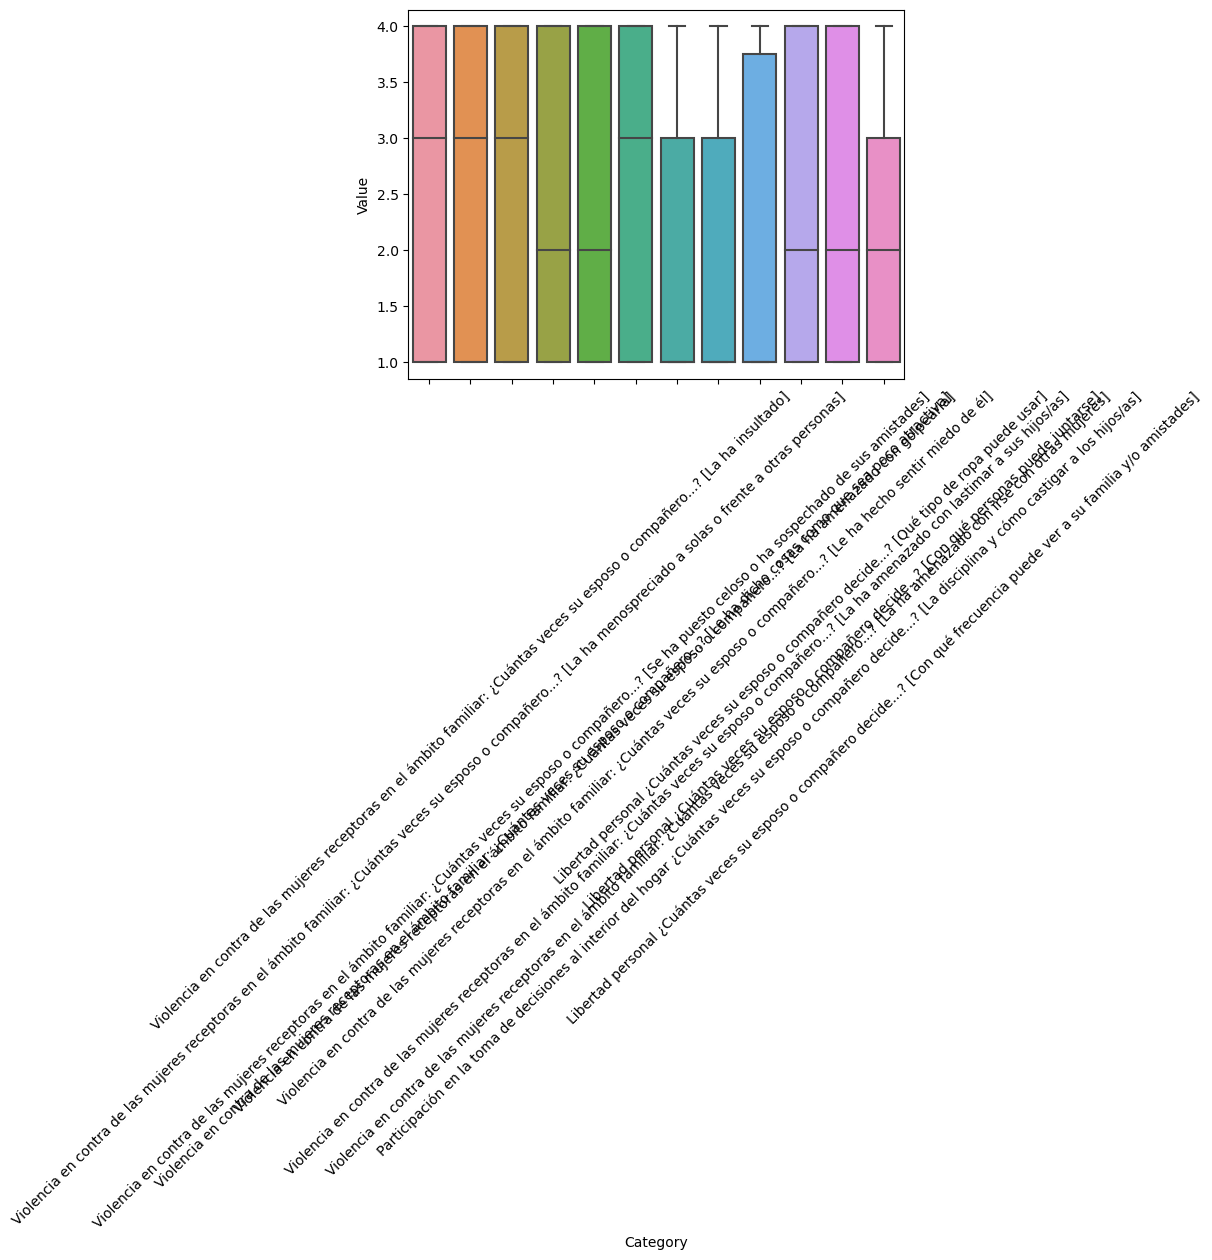

In [61]:
temp_df=psyc_viol[["Violencia",'Edad', 'Nivel máximo de escolaridad','Estado civil','Si tiene hijos/as ¿Cuántos?','Ocupación (selecciona todas las que apliquen).1',
              'Ingreso semanal','¿Su ingreso es estable? es decir, ¿cada mes recibe la misma cantidad?',"Monto de la transferencia 1"]]

temp_df.columns=["Violencia","Edad","Escolaridad","Edo_Civil", "Hijos", "Ocupacion", "Ingreso_semanal","Estabilidad","Monto"]

temp_df=temp_df.dropna(subset="Violencia")
mult_reg_y=temp_df["Violencia"]
mult_reg_x=temp_df[[ "Edad","Escolaridad","Edo_Civil", "Hijos", "Ocupacion", "Ingreso_semanal","Estabilidad","Monto"]].fillna(0)
cols_to_exclude=["Violencia",'Edad', 'Nivel máximo de escolaridad','Estado civil','Si tiene hijos/as ¿Cuántos?','Ocupación (selecciona todas las que apliquen).1',
              'Ingreso semanal','¿Su ingreso es estable? es decir, ¿cada mes recibe la misma cantidad?',"Monto de la transferencia 1"]

selected_columns = psyc_viol.loc[:, ~psyc_viol.columns.isin(cols_to_exclude)]
df_long = pd.melt(selected_columns, var_name='Category', value_name='Value')

# Create a boxplot using Seaborn
sns.boxplot(x='Category', y='Value', data=df_long)
plt.xticks(rotation=45)

# Show the plot
plt.show()


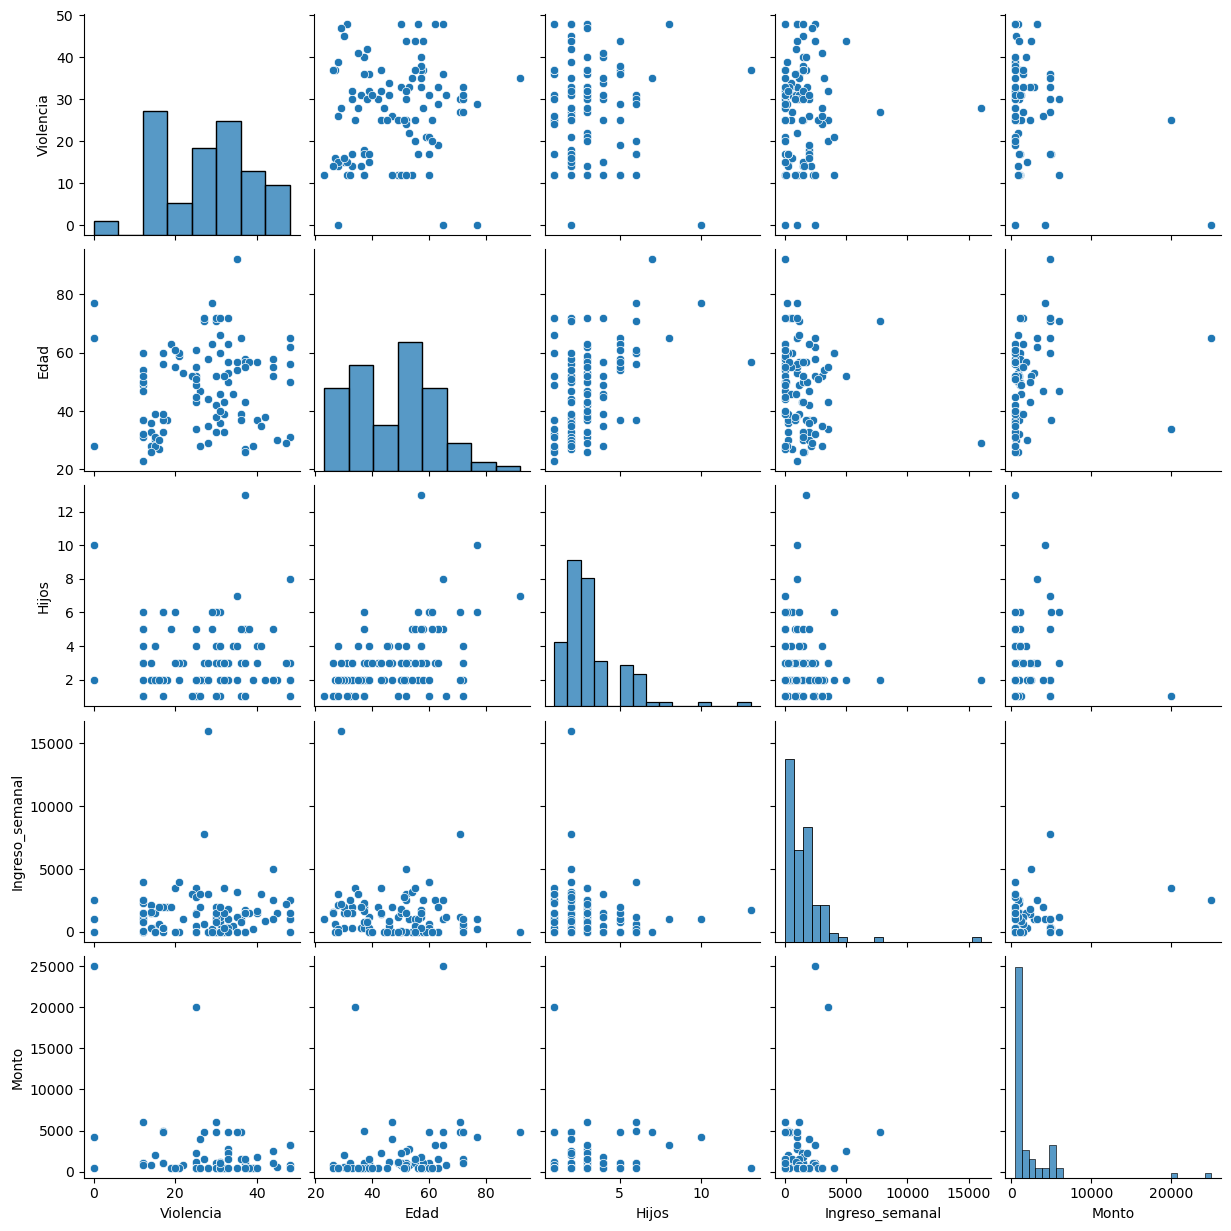

In [27]:
#Visually check for multicolinearity
sns.pairplot(temp_df)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(mult_reg_x, mult_reg_y , test_size=0.1)
ols_formula= "Violencia ~ C(Escolaridad) + C(Edo_Civil) +  Hijos + C(Ocupacion) + C(Estabilidad)"
ols_data = pd.concat([X_train,y_train],axis=1)
OLS =ols(formula=ols_formula, data=ols_data)
model=OLS.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Violencia   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     2.602
Date:                Sat, 02 Dec 2023   Prob (F-statistic):            0.00272
Time:                        20:41:07   Log-Likelihood:                -342.64
No. Observations:                  95   AIC:                             719.3
Df Residuals:                      78   BIC:                             762.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            18.8706      4.366      4.322      0.000      10.179      27.562
C(Escolaridad)[T.Primaria]           -4.9529      3.432     -1.443      0.153     -11.786       1.880
C(Escolaridad)[T.Secundaria]         -3.9530      3.125     -1.265      0.210     -10.175       2.269
C(Escolaridad)[T.Sin escolaridad]    -3.0272      5.275     -0.574      0.568     -13.529       7.475
C(Escolaridad)[T.Universidad]         5.0194      5.852      0.858      0.394      -6.631      16.670
C(Edo_Civil)[T.Divorciada]            3.1861      4.556      0.699      0.486      -5.884      12.256
C(Edo_Civil)[T.Separada]              7.5508      5.534      1.364      0.176      -3.467      18.568
C(Edo_Civil)[T.Soltera]               4.1987      3.745      1.121      0.266      -3.256      11.654
C(Edo_Civil)[T.Unión libre]          -1.4698      2.759     -0.533      0.596      -6.962       4.023
C(Edo_Civil)[T.Viuda]                 3.4708      3.989      0.870      0.387      -4.471      11.412
C(Ocupacion)[T.Desempleada]           2.9592      6.774      0.437      0.663     -10.526      16.445
C(Ocupacion)[T.Empleada]              8.8727      3.229      2.748      0.007       2.445      15.300
C(Ocupacion)[T.Emprendedora]          9.2753      2.891      3.209      0.002       3.520      15.030
C(Ocupacion)[T.Jubilada]              4.0300     10.752      0.375      0.709     -17.376      25.436
C(Ocupacion)[T.Jubilado]            -17.3971      8.803     -1.976      0.052     -34.923       0.129
C(Estabilidad)[T.No estable]          1.8538      3.076      0.603      0.549      -4.271       7.978
Hijos                                 1.4441      0.630      2.291      0.025       0.189       2.699
==============================================================================
Omnibus:                        0.422   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.810   Jarque-Bera (JB):                0.449
Skew:                           0.154   Prob(JB):                        0.799
Kurtosis:                       2.862   Cond. No.                         42.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

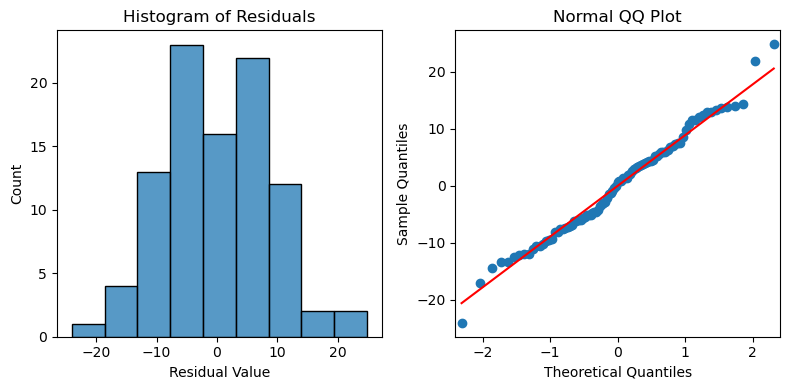

In [29]:
#Check for normality of residuals

residuals=model.resid

# Create a 1x2 plot figure.
fig, axes = plt.subplots(1, 2, figsize = (8,4))


sns.histplot(residuals, ax=axes[0])

# Set the x label of the residual plot.
axes[0].set_xlabel("Residual Value")

# Set the title of the residual plot.
axes[0].set_title("Histogram of Residuals")

# Create a Q-Q plot of the residuals.

sm.qqplot(residuals, line='s',ax = axes[1])

# Set the title of the Q-Q plot.
axes[1].set_title("Normal QQ Plot")

# Use matplotlib's tight_layout() function to add space between plots for a cleaner appearance.
plt.tight_layout()

# Show the plot.
plt.show()

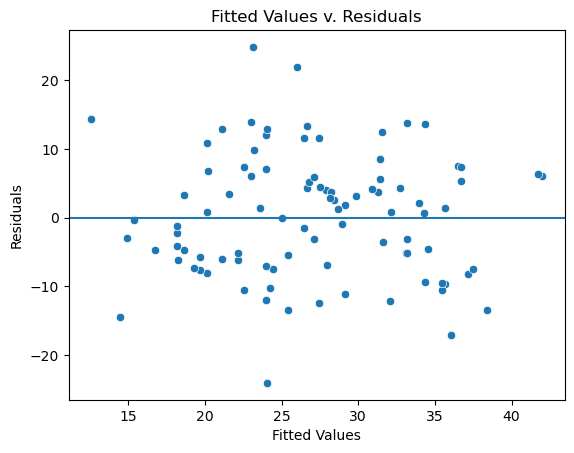

In [30]:
#Check for constant variance

fig = sns.scatterplot(x = model.fittedvalues, y = model.resid)

# Set the x axis label.
fig.set_xlabel("Fitted Values")

# Set the y axis label.
fig.set_ylabel("Residuals")

# Set the title.
fig.set_title("Fitted Values v. Residuals")

# Add a line at y = 0 to visualize the variance of residuals above and below 0.

fig.axhline(0)

# Show the plot.
plt.show()

In [31]:
# Numerically check for multicolinearity
# Create a subset of the data with the continous independent variables. 
X = mult_reg_x[["Hijos", "Monto",]]

# Calculate the variance inflation factor for each variable.
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Create a DataFrame with the VIF results for the column names in X.
df_vif = pd.DataFrame(vif, index=X.columns, columns = ['VIF'])

# Display the VIF results.
df_vif

,VIF
Hijos,1.106083
Monto,1.106083


In [32]:
# Make predictions on the test data
predictions = model.predict(X_test)

# Assuming y_test is a Series, you can compare the predictions with the actual values
results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Display the results
print(results)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

     Actual  Predicted
14     12.0  19.633877
19     12.0  23.202975
97     25.0  29.964370
55     33.0  29.976395
37      0.0  31.941956
16     45.0  36.083076
10     17.0  28.532267
57     30.0  27.907058
73     36.0  31.689417
83     37.0  32.607580
103    41.0  32.049923
Mean Squared Error: 142.97471721949398
R-squared: 0.22205500568581837


Interpretación: al rededor del 34% de la variación en la violencia física puede ser explicada usando las variables propuestas en el modelo

# Violencia Sexual

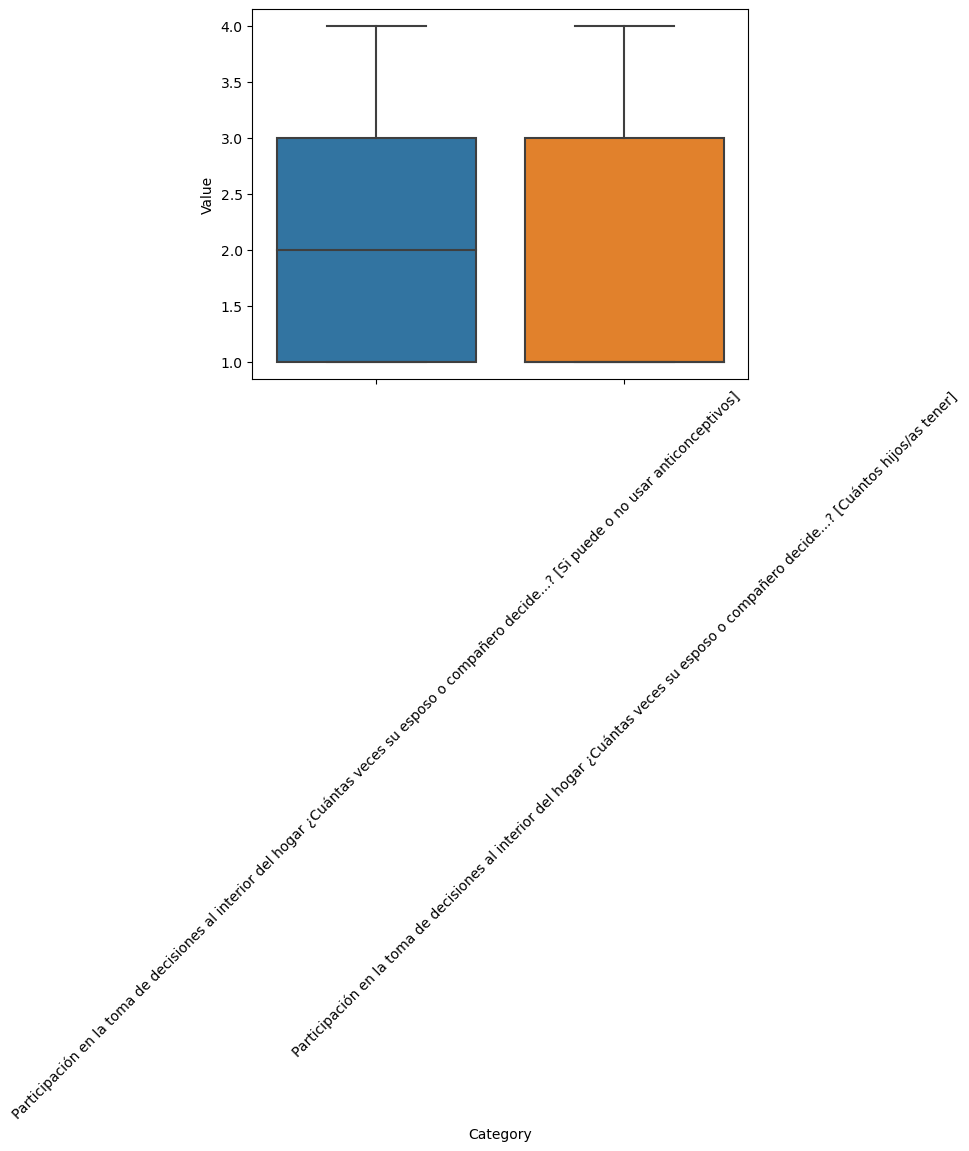

In [62]:
temp_df=sex_viol[["Violencia",'Edad', 'Nivel máximo de escolaridad','Estado civil','Si tiene hijos/as ¿Cuántos?','Ocupación (selecciona todas las que apliquen).1',
              'Ingreso semanal','¿Su ingreso es estable? es decir, ¿cada mes recibe la misma cantidad?',"Monto de la transferencia 1"]]

temp_df.columns=["Violencia","Edad","Escolaridad","Edo_Civil", "Hijos", "Ocupacion", "Ingreso_semanal","Estabilidad","Monto"]

temp_df=temp_df.dropna(subset="Violencia")
mult_reg_y=temp_df["Violencia"]
mult_reg_x=temp_df[[ "Edad","Escolaridad","Edo_Civil", "Hijos", "Ocupacion", "Ingreso_semanal","Estabilidad","Monto"]].fillna(0)
cols_to_exclude=["Violencia",'Edad', 'Nivel máximo de escolaridad','Estado civil','Si tiene hijos/as ¿Cuántos?','Ocupación (selecciona todas las que apliquen).1',
              'Ingreso semanal','¿Su ingreso es estable? es decir, ¿cada mes recibe la misma cantidad?',"Monto de la transferencia 1"]

selected_columns = sex_viol.loc[:, ~sex_viol.columns.isin(cols_to_exclude)]
df_long = pd.melt(selected_columns, var_name='Category', value_name='Value')

# Create a boxplot using Seaborn
sns.boxplot(x='Category', y='Value', data=df_long)
plt.xticks(rotation=45)

# Show the plot
plt.show()


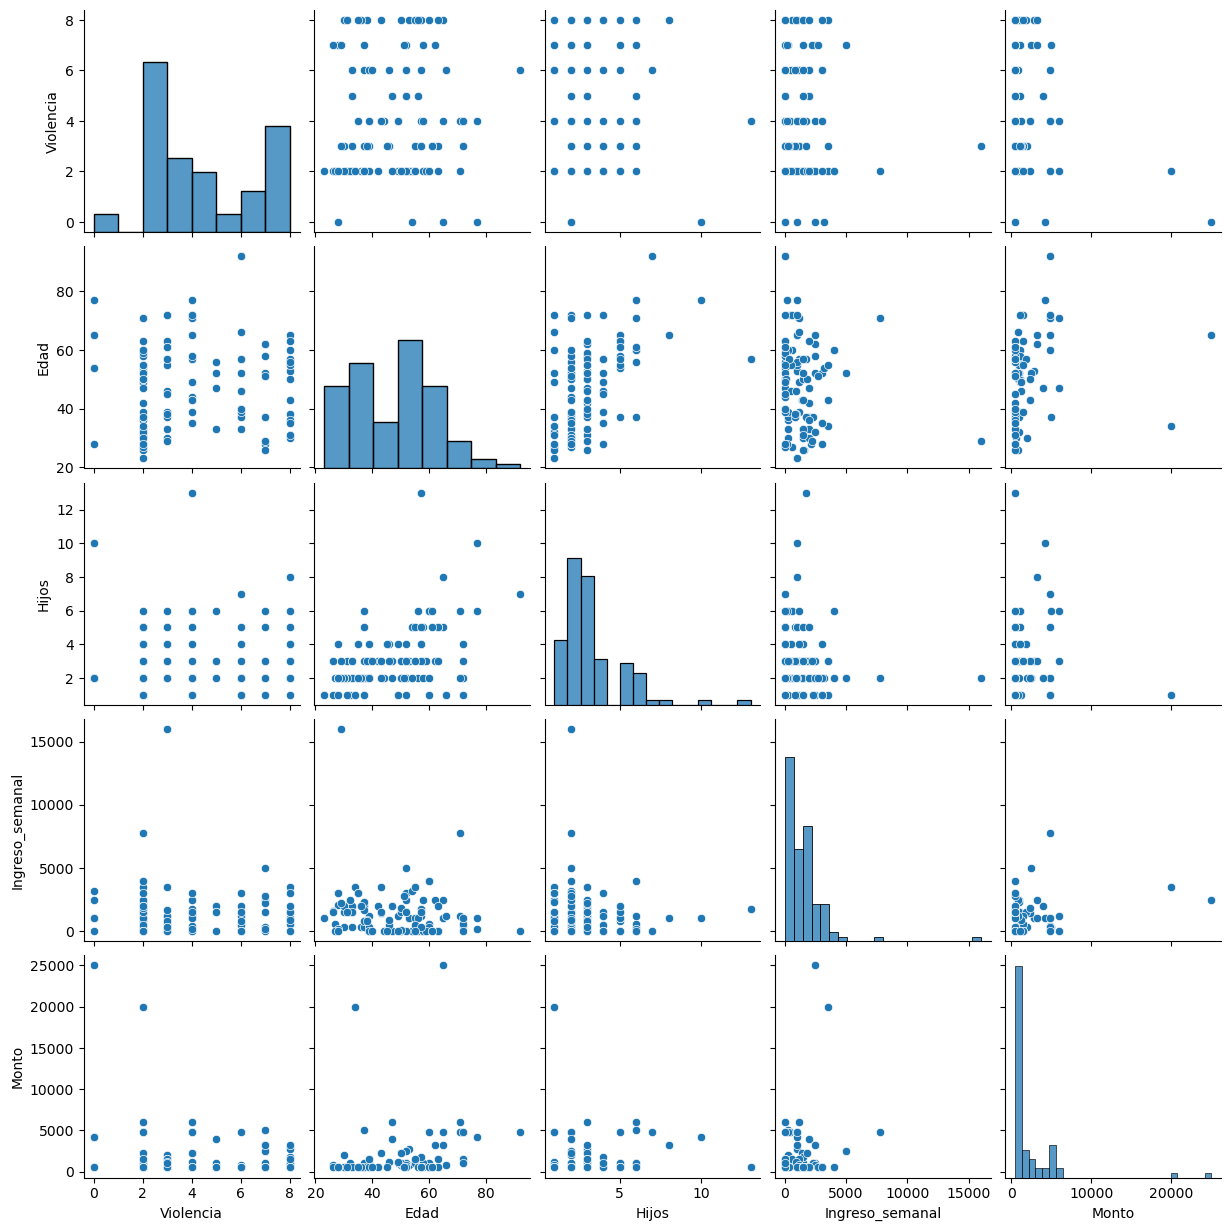

In [34]:
#Visually check for multicolinearity
sns.pairplot(temp_df)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(mult_reg_x, mult_reg_y , test_size=0.3)
ols_formula= "Violencia ~ C(Escolaridad) + C(Edo_Civil) +  Hijos + C(Ocupacion) + C(Estabilidad)"
ols_data = pd.concat([X_train,y_train],axis=1)
OLS =ols(formula=ols_formula, data=ols_data)
model=OLS.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Violencia   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                    0.8266
Date:                Sat, 02 Dec 2023   Prob (F-statistic):              0.651
Time:                        20:41:18   Log-Likelihood:                -158.11
No. Observations:                  74   AIC:                             350.2
Df Residuals:                      57   BIC:                             389.4
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             3.0300      1.176      2.576      0.013       0.675       5.385
C(Escolaridad)[T.Primaria]           -0.9363      0.897     -1.044      0.301      -2.732       0.859
C(Escolaridad)[T.Secundaria]         -0.2988      0.785     -0.381      0.705      -1.871       1.274
C(Escolaridad)[T.Sin escolaridad]    -0.3426      1.475     -0.232      0.817      -3.295       2.610
C(Escolaridad)[T.Universidad]         0.6378      1.789      0.357      0.723      -2.944       4.220
C(Edo_Civil)[T.Divorciada]            0.8856      1.215      0.729      0.469      -1.547       3.319
C(Edo_Civil)[T.Separada]              2.4136      1.284      1.880      0.065      -0.158       4.985
C(Edo_Civil)[T.Soltera]               0.0104      1.023      0.010      0.992      -2.038       2.059
C(Edo_Civil)[T.Unión libre]           0.5552      0.765      0.726      0.471      -0.977       2.087
C(Edo_Civil)[T.Viuda]                 1.2767      1.027      1.243      0.219      -0.780       3.333
C(Ocupacion)[T.Desempleada]          -0.4579      1.824     -0.251      0.803      -4.111       3.195
C(Ocupacion)[T.Empleada]              0.3954      0.843      0.469      0.641      -1.292       2.083
C(Ocupacion)[T.Emprendedora]          0.6756      0.787      0.858      0.394      -0.900       2.252
C(Ocupacion)[T.Jubilada]             -0.6939      2.617     -0.265      0.792      -5.934       4.547
C(Ocupacion)[T.Jubilado]             -4.4017      2.201     -2.000      0.050      -8.808       0.005
C(Estabilidad)[T.No estable]         -0.0478      0.864     -0.055      0.956      -1.778       1.682
Hijos                                 0.2399      0.173      1.388      0.171      -0.106       0.586
==============================================================================
Omnibus:                        8.362   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                7.868
Skew:                           0.730   Prob(JB):                       0.0196
Kurtosis:                       2.351   Cond. No.                         39.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

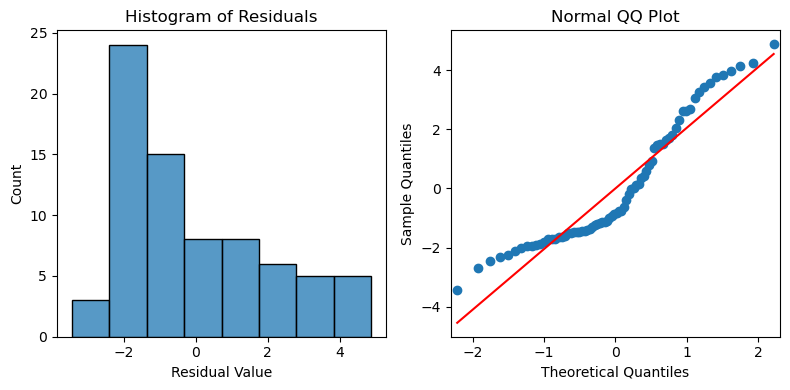

In [36]:
#Check for normality of residuals

residuals=model.resid

# Create a 1x2 plot figure.
fig, axes = plt.subplots(1, 2, figsize = (8,4))


sns.histplot(residuals, ax=axes[0])

# Set the x label of the residual plot.
axes[0].set_xlabel("Residual Value")

# Set the title of the residual plot.
axes[0].set_title("Histogram of Residuals")

# Create a Q-Q plot of the residuals.

sm.qqplot(residuals, line='s',ax = axes[1])

# Set the title of the Q-Q plot.
axes[1].set_title("Normal QQ Plot")

# Use matplotlib's tight_layout() function to add space between plots for a cleaner appearance.
plt.tight_layout()

# Show the plot.
plt.show()

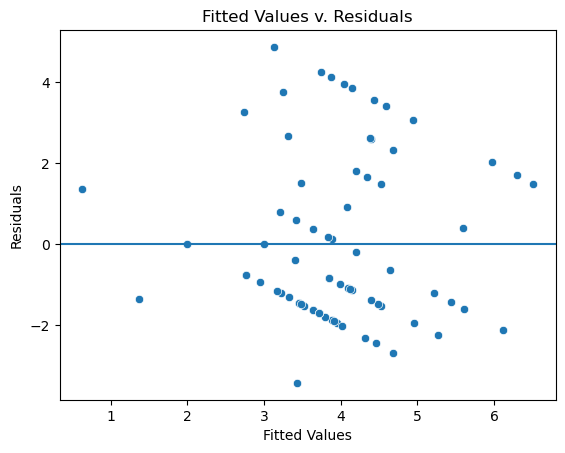

In [37]:
#Check for constant variance

fig = sns.scatterplot(x = model.fittedvalues, y = model.resid)

# Set the x axis label.
fig.set_xlabel("Fitted Values")

# Set the y axis label.
fig.set_ylabel("Residuals")

# Set the title.
fig.set_title("Fitted Values v. Residuals")

# Add a line at y = 0 to visualize the variance of residuals above and below 0.

fig.axhline(0)

# Show the plot.
plt.show()

In [38]:
# Numerically check for multicolinearity
# Create a subset of the data with the continous independent variables. 
X = mult_reg_x[["Hijos", "Monto",]]

# Calculate the variance inflation factor for each variable.
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Create a DataFrame with the VIF results for the column names in X.
df_vif = pd.DataFrame(vif, index=X.columns, columns = ['VIF'])

# Display the VIF results.
df_vif

,VIF
Hijos,1.106083
Monto,1.106083


In [39]:
# Make predictions on the test data
predictions = model.predict(X_test)

# Assuming y_test is a Series, you can compare the predictions with the actual values
results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Display the results
print(results)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

     Actual  Predicted
92      6.0   2.765821
60      5.0   3.489155
35      2.0   3.163332
4       2.0   3.526405
19      2.0   3.749887
5       2.0   3.163332
62      8.0   4.505830
98      0.0   4.396300
72      8.0   4.460621
78      2.0   3.870441
47      5.0   5.615057
97      7.0   5.033377
27      2.0   3.321060
57      4.0   4.762370
15      2.0   3.883172
46      7.0   3.868024
68      3.0   4.401741
73      6.0   3.609360
7       2.0   4.123119
88      3.0   3.245715
82      4.0   6.252515
84      2.0   5.164244
81      0.0   3.616978
33      2.0   2.923386
10      6.0   3.558774
75      7.0   3.171686
18      2.0   4.198464
28      8.0   4.678357
102     7.0   3.908187
90      3.0   4.590329
24      8.0   3.209045
96      2.0   3.201427
Mean Squared Error: 6.330261429985517
R-squared: -0.028428955149162105


Interpretación: Este modelo no cumple con las suposiciones de una regresión múltiple, por lo que no puede ser reportado como estadísticamente significativo, y otros métodos deberán ser utilizados